<a href="https://colab.research.google.com/github/futaoo/kg-climate-analysis/blob/main/kg_climate_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/KGExtension-code/')

Mounted at /content/drive


Pip Packages

In [ ]:
!pip install --upgrade pip && pip install lazypredict

     |████████████████████████████████| 2.1 MB 8.5 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.9/25.9 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 KB 28.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.6/127.6 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install BorutaShap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.8/564.8 KB 10.9 MB/s eta 0:00:00


Package Dependency

In [ ]:
import pandas as pd
from pandas import DataFrame
from pandas import concat
import lazypredict

Functions

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


def prcp_map(x):
    value = 'yes' if x > 0 else 'no'
    return value

def date_map(x):
	value = x[:10]
	return value

def categorize_lazy_predict(df, col_list):
    temp_dict = {'Value':[], 'Eval_method':[],'Model':[]}
    for col in col_list:
        for index, row in df[[col]].iterrows():
            temp_dict['Value'].append(row[col])
            temp_dict['Eval_method'].append(col)
            temp_dict['Model'].append(index)
    return pd.DataFrame.from_dict(temp_dict)


def df_to_supervised(df, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = list(df.columns)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('%s(t-%d)' % (j, i)) for j in n_vars]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('%s(t)' % j) for j in n_vars]
		else:
			names += [('%s(t+%d)' % (j, i)) for j in n_vars]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

###Data Preprocess - A sample of NOAA's weather data combined with atmospheric variables from Link-Climate (using data from Nearest Sensor)

In [ ]:
# NOAA csv weather data
df_climate = pd.read_csv('./datasets/climate-features.csv').pivot(index='date', columns='datatype', values='simpleresult').fillna(0)

# PurpleAir's air sensor data
df_air = pd.read_csv('./datasets/air-features-u.csv')

# Join two tables on the date column
df_merge = pd.merge(df_air, df_climate, left_on="created_at", right_on="date").sort_values(by=['created_at']).reset_index(drop=True)
# df_merge['Diff_T'] = df_merge['TMAX']-df_merge['TMIN']

df_merge

,created_at,Humidity_%,PM2.5_ATM_ug/m3,Pressure_hpa,PRCP,SNWD,TAVG,TMAX,TMIN
0,2019-06-01,57.95,13.05,1013.97,1.20,0.00,13.30,20.00,7.50
1,2019-06-02,51.37,2.18,1001.23,0.00,0.00,14.90,19.30,13.60
2,2019-06-03,51.49,3.13,1006.51,9.30,0.00,11.50,17.20,8.60
3,2019-06-04,69.54,7.79,1001.58,19.70,0.00,10.40,12.40,7.90
4,2019-06-05,67.70,2.38,1001.83,0.30,0.00,9.90,12.60,8.80
...,...,...,...,...,...,...,...,...,...
362,2020-05-28,44.68,10.57,1029.93,0.00,0.00,15.30,23.30,10.10
363,2020-05-29,37.91,8.45,1023.37,0.00,0.00,15.80,23.50,11.30
364,2020-05-30,37.19,8.03,1020.37,0.00,0.00,14.90,22.00,9.20
365,2020-05-31,39.92,15.02,1020.93,0.00,0.00,14.60,21.50,9.00


In [ ]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [ ]:
#feature selection from all variables by boruta algorithm
from BorutaShap import BorutaShap

baseline = ['PRCP','SNWD', 'TAVG', 'TMAX', 'TMIN']

df_select = df_merge.drop(columns='created_at')

df_xy = df_to_supervised(df_select, 2, 1)

names = list();
names += [('%s(t)' % j) for j in list(df_select.columns)]
names.remove('PRCP(t)')
drop_cols = names
df_xy = df_xy.drop(columns=drop_cols)

#y
d_y = df_xy['PRCP(t)'].map(prcp_map)
label_binarizer = preprocessing.LabelBinarizer()
y = label_binarizer.fit_transform(d_y).ravel()

#X
X = df_xy.drop(columns='PRCP(t)')




In [ ]:
from BorutaShap import BorutaShap

Feature_Selector = BorutaShap(importance_measure='shap', classification=True)

Feature_Selector.fit(X=X, y=y, n_trials=100, sample=False, train_or_test = 'test', normalize=True, verbose=True)

Feature_Selector.TentativeRoughFix()


  0%|          | 0/100 [00:00<?, ?it/s]

4 attributes confirmed important: ['Pressure_hpa(t-1)', 'Humidity_%(t-1)', 'Pressure_hpa(t-2)', 'PRCP(t-1)']
11 attributes confirmed unimportant: ['SNWD(t-2)', 'TAVG(t-2)', 'PM2.5_ATM_ug/m3(t-1)', 'TAVG(t-1)', 'TMAX(t-1)', 'PRCP(t-2)', 'PM2.5_ATM_ug/m3(t-2)', 'TMAX(t-2)', 'SNWD(t-1)', 'Humidity_%(t-2)', 'TMIN(t-1)']
1 tentative attributes remains: ['TMIN(t-2)']
0 tentative features are now accepted: []
1 tentative features are now rejected: ['TMIN(t-2)']


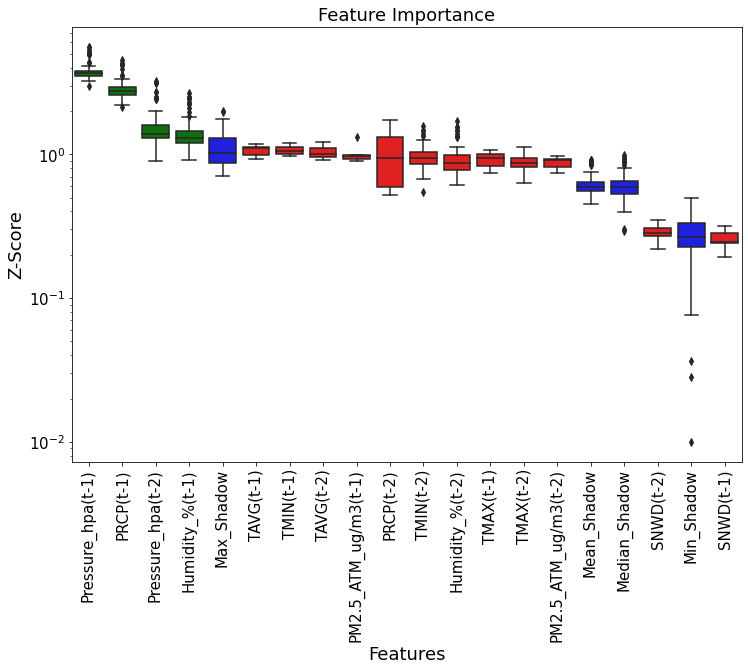

In [ ]:
Feature_Selector.plot(which_features='all', X_size=15, figsize=(12,8))

###An example of the results given by classifiers

In [ ]:
#baseline

df_select = df_merge[['PRCP']]
values = df_select.values
df_learn = series_to_supervised(values,2,1)
df_learn['var1(t)'] = df_learn['var1(t)'].map(prcp_map)

label_binarizer = preprocessing.LabelBinarizer()
y = label_binarizer.fit_transform(df_learn['var1(t)']).ravel()
X = df_learn.drop(columns=['var1(t)'])
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.33, stratify=y, random_state=42)


clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

models_B = categorize_lazy_predict(models, ['Accuracy','F1 Score', 'ROC AUC'])
models_B

100%|██████████| 29/29 [00:02<00:00, 13.26it/s]


,Value,Eval_method,Model
0,0.69,Accuracy,SVC
1,0.69,Accuracy,Perceptron
2,0.69,Accuracy,LGBMClassifier
3,0.68,Accuracy,LabelSpreading
4,0.67,Accuracy,AdaBoostClassifier
...,...,...,...
76,0.50,ROC AUC,RidgeClassifierCV
77,0.50,ROC AUC,SGDClassifier
78,0.50,ROC AUC,CalibratedClassifierCV
79,0.50,ROC AUC,LinearDiscriminantAnalysis


In [ ]:
models[['Accuracy','ROC AUC','F1 Score']].to_latex()

'\\begin{tabular}{lrrr}\n\\toprule\n{} &  Accuracy &  ROC AUC &  F1 Score \\\\\nModel                         &           &          &           \\\\\n\\midrule\nSVC                           &      0.69 &     0.71 &      0.70 \\\\\nPerceptron                    &      0.69 &     0.70 &      0.69 \\\\\nLGBMClassifier                &      0.69 &     0.69 &      0.69 \\\\\nLabelSpreading                &      0.68 &     0.69 &      0.68 \\\\\nAdaBoostClassifier            &      0.67 &     0.68 &      0.67 \\\\\nLabelPropagation              &      0.66 &     0.68 &      0.66 \\\\\nBernoulliNB                   &      0.65 &     0.67 &      0.65 \\\\\nLogisticRegression            &      0.69 &     0.67 &      0.68 \\\\\nPassiveAggressiveClassifier   &      0.63 &     0.66 &      0.62 \\\\\nXGBClassifier                 &      0.64 &     0.66 &      0.65 \\\\\nKNeighborsClassifier          &      0.65 &     0.65 &      0.65 \\\\\nExtraTreeClassifier           &      0.63 &     0.65 &   

###Sensors at remote distance from weather station

In [ ]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
#feature selection from all variables by boruta algorithm
from BorutaShap import BorutaShap

def select_features(df_select, importance_measure='shap', classification=True, n_trials=100, sample=False, train_or_test = 'test', normalize=True, verbose=True):

    df_xy = df_to_supervised(df_select, 2, 1)

    names = list();
    names += [('%s(t)' % j) for j in list(df_select.columns)]
    names.remove('PRCP(t)')
    drop_cols = names
    df_xy = df_xy.drop(columns=drop_cols)

    #y
    d_y = df_xy['PRCP(t)'].map(prcp_map)
    label_binarizer = preprocessing.LabelBinarizer()
    y = label_binarizer.fit_transform(d_y).ravel()

    #X
    X = df_xy.drop(columns='PRCP(t)')

    selector = BorutaShap(importance_measure=importance_measure, classification=classification)

    selector.fit(X=X, y=y, n_trials=n_trials, sample=sample, train_or_test=train_or_test, normalize=normalize, verbose=verbose)

    subset = selector.Subset()
    subset['PRCP(t)'] = y

    return subset

In [ ]:
# NOAA csv weather data
df_climate = pd.read_csv('./datasets/climate-features.csv').pivot(index='date', columns='datatype', values='simpleresult').fillna(0)
# PurpleAir's air sensor data
df_air = pd.read_csv('./datasets/air-features-u.csv')
# Join two tables on the date column
df_merge = pd.merge(df_air, df_climate, left_on="created_at", right_on="date").sort_values(by=['created_at']).reset_index(drop=True)
# df_merge['Diff_T'] = df_merge['TMAX']-df_merge['TMIN']
df_merge26695 = df_merge


df_air_2021B = pd.read_csv('./datasets/sensor91889-B.csv')
df_air_2021A = pd.read_csv('./datasets/sensor91889-A.csv')
df_air_2021 = pd.merge(df_air_2021A, df_air_2021B, left_on="created_at", right_on="created_at")
df_climate2021 = pd.read_csv('./datasets/NOAA-2021-2022.csv')
df_air_2021['created_at'] = df_air_2021['created_at'].map(date_map)
df_merge2021 = pd.merge(df_air_2021, df_climate2021, left_on="created_at", right_on="DATE").sort_values(by=['created_at']).reset_index(drop=True).fillna(0)
df_merge2021 = df_merge2021[['created_at','Humidity_%', 'Pressure_hpa', 'PM2.5_ATM_ug/m3_y', 'PRCP', 'SNWD', 'TAVG', 'TMAX', 'TMIN']]
df_merge2021.rename(columns={'PM2.5_ATM_ug/m3_y':'PM2.5_ATM_ug/m3'}, inplace = True)
df_merge91889 = df_merge2021



df_air_2021B = pd.read_csv('./datasets/sensor59111-B.csv')
df_air_2021A = pd.read_csv('./datasets/sensor59111-A.csv')
df_air_2021 = pd.merge(df_air_2021A, df_air_2021B, left_on="created_at", right_on="created_at")
df_climate2021 = pd.read_csv('./datasets/NOAA-2021-2022.csv')
df_air_2021['created_at'] = df_air_2021['created_at'].map(date_map)
df_merge2021 = pd.merge(df_air_2021, df_climate2021, left_on="created_at", right_on="DATE").sort_values(by=['created_at']).reset_index(drop=True).fillna(0)
df_merge2021 = df_merge2021[['created_at','Humidity_%', 'Pressure_hpa', 'PM2.5_ATM_ug/m3_y', 'PRCP', 'SNWD', 'TAVG', 'TMAX', 'TMIN']]
df_merge2021.rename(columns={'PM2.5_ATM_ug/m3_y':'PM2.5_ATM_ug/m3'}, inplace = True)
df_merge59111 = df_merge2021



In [ ]:
df_merge91889
# col_names = list(df_merge2021.columns.values)
# print(col_names)

,created_at,Humidity_%,Pressure_hpa,PM2.5_ATM_ug/m3,PRCP,SNWD,TAVG,TMAX,TMIN
0,2021-01-01,71.32,1008.76,13.71,0.00,0.00,36.00,41,31
1,2021-01-02,71.62,1013.01,14.64,0.00,0.00,33.00,39,29
2,2021-01-03,67.80,1016.19,7.89,0.15,0.00,33.00,40,29
3,2021-01-04,63.06,1019.36,3.25,0.06,0.00,39.00,42,29
4,2021-01-05,58.01,1019.85,2.03,0.21,0.00,37.00,42,35
...,...,...,...,...,...,...,...,...,...
361,2021-12-28,76.00,654.02,17.43,0.12,0.00,44.00,57,42
362,2021-12-29,76.00,654.02,5.29,0.01,0.00,51.00,57,38
363,2021-12-30,76.00,654.02,4.56,0.30,0.00,55.00,57,51
364,2021-12-31,76.00,654.02,8.29,0.02,0.00,55.00,59,53


In [ ]:
dfs = [df_merge26695, df_merge59111, df_merge91889]

baseline = ['PRCP','SNWD','TAVG','TMAX','TMIN']


noaa = []
noaa_plus = []

models_diff = []

sensors = ['s26695 - 3.7km', 's59111 - 8km', 's91889 - 18km']

count = 0

for df in dfs:

    select_Xy = select_features(df[baseline],n_trials=50)
    noaa.append(select_Xy)
    X = select_Xy.drop(columns='PRCP(t)')
    y = select_Xy['PRCP(t)'].values
    X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.33, stratify=y, random_state=42)
    clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
    models_0,predictions = clf.fit(X_train, X_test, y_train, y_test)

    select_Xy = select_features(df.drop(columns='created_at'),n_trials=20)
    noaa_plus.append(select_Xy)
    X = select_Xy.drop(columns='PRCP(t)')
    y = select_Xy['PRCP(t)'].values
    X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.33, stratify=y, random_state=42)
    clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
    models_1,predictions = clf.fit(X_train, X_test, y_train, y_test)

    models_sensor = categorize_lazy_predict(models_1.subtract(models_0, fill_value=0), ['Accuracy','F1 Score', 'ROC AUC'])
    models_sensor['Sensor'] = sensors[count]
    models_diff.append(models_sensor)

    count+=1

  0%|          | 0/20 [00:00<?, ?it/s]

  3%|▎         | 1/29 [00:00<00:03,  7.88it/s]

3 attributes confirmed important: ['TMIN(t-2)', 'PRCP(t-2)', 'PRCP(t-1)']
7 attributes confirmed unimportant: ['TAVG(t-2)', 'SNWD(t-2)', 'TMAX(t-1)', 'TMIN(t-1)', 'TAVG(t-1)', 'SNWD(t-1)', 'TMAX(t-2)']
0 tentative attributes remains: []


100%|██████████| 29/29 [00:01<00:00, 25.58it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

  3%|▎         | 1/29 [00:00<00:03,  8.69it/s]

4 attributes confirmed important: ['Pressure_hpa(t-2)', 'Humidity_%(t-1)', 'Pressure_hpa(t-1)', 'PRCP(t-1)']
10 attributes confirmed unimportant: ['PRCP(t-2)', 'PM2.5_ATM_ug/m3(t-2)', 'TAVG(t-2)', 'SNWD(t-2)', 'TMAX(t-1)', 'PM2.5_ATM_ug/m3(t-1)', 'TMIN(t-1)', 'TAVG(t-1)', 'SNWD(t-1)', 'TMAX(t-2)']
2 tentative attributes remains: ['Humidity_%(t-2)', 'TMIN(t-2)']


100%|██████████| 29/29 [00:01<00:00, 25.21it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

  3%|▎         | 1/29 [00:00<00:03,  9.22it/s]

2 attributes confirmed important: ['PRCP(t-2)', 'PRCP(t-1)']
5 attributes confirmed unimportant: ['TAVG(t-2)', 'SNWD(t-2)', 'TMAX(t-1)', 'TMIN(t-1)', 'SNWD(t-1)']
3 tentative attributes remains: ['TAVG(t-1)', 'TMIN(t-2)', 'TMAX(t-2)']


100%|██████████| 29/29 [00:01<00:00, 27.49it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

  3%|▎         | 1/29 [00:00<00:03,  8.37it/s]

4 attributes confirmed important: ['Pressure_hpa(t-2)', 'Pressure_hpa(t-1)', 'PRCP(t-2)', 'PRCP(t-1)']
8 attributes confirmed unimportant: ['PM2.5_ATM_ug/m3(t-2)', 'TAVG(t-2)', 'SNWD(t-2)', 'TAVG(t-1)', 'TMAX(t-1)', 'TMIN(t-1)', 'Humidity_%(t-2)', 'SNWD(t-1)']
4 tentative attributes remains: ['Humidity_%(t-1)', 'TMIN(t-2)', 'PM2.5_ATM_ug/m3(t-1)', 'TMAX(t-2)']


100%|██████████| 29/29 [00:01<00:00, 25.77it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

  3%|▎         | 1/29 [00:00<00:03,  8.41it/s]

2 attributes confirmed important: ['PRCP(t-2)', 'PRCP(t-1)']
5 attributes confirmed unimportant: ['TAVG(t-2)', 'SNWD(t-2)', 'TMAX(t-1)', 'TMIN(t-1)', 'SNWD(t-1)']
3 tentative attributes remains: ['TAVG(t-1)', 'TMIN(t-2)', 'TMAX(t-2)']


100%|██████████| 29/29 [00:01<00:00, 27.25it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

  3%|▎         | 1/29 [00:00<00:03,  8.63it/s]

3 attributes confirmed important: ['PRCP(t-2)', 'PRCP(t-1)', 'PM2.5_ATM_ug/m3(t-1)']
11 attributes confirmed unimportant: ['Pressure_hpa(t-2)', 'Pressure_hpa(t-1)', 'PM2.5_ATM_ug/m3(t-2)', 'TAVG(t-2)', 'SNWD(t-2)', 'Humidity_%(t-2)', 'Humidity_%(t-1)', 'TMIN(t-1)', 'TAVG(t-1)', 'SNWD(t-1)', 'TMAX(t-2)']
2 tentative attributes remains: ['TMAX(t-1)', 'TMIN(t-2)']


100%|██████████| 29/29 [00:01<00:00, 26.47it/s]


In [ ]:
models_concat = models_diff[0].append(models_diff[1], ignore_index=True).append(models_diff[2], ignore_index=True)

In [ ]:
models_0.index.values

array(['NearestCentroid', 'LinearSVC', 'CalibratedClassifierCV',
       'BernoulliNB', 'LogisticRegression', 'SGDClassifier', 'GaussianNB',
       'RidgeClassifierCV', 'RidgeClassifier',
       'LinearDiscriminantAnalysis', 'SVC',
       'QuadraticDiscriminantAnalysis', 'LabelPropagation',
       'LabelSpreading', 'Perceptron', 'KNeighborsClassifier',
       'AdaBoostClassifier', 'BaggingClassifier', 'NuSVC',
       'RandomForestClassifier', 'ExtraTreesClassifier', 'LGBMClassifier',
       'ExtraTreeClassifier', 'DecisionTreeClassifier', 'XGBClassifier',
       'PassiveAggressiveClassifier', 'DummyClassifier'], dtype=object)

####Classification results statistics for sensors at different distances

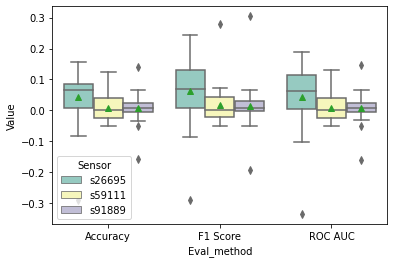

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1,1,sharex=True)
# models_concat.boxplot(column=['Accuracy','F1 Score','ROC AUC'], by='feature', ax=axs)
sns.boxplot(x='Eval_method',y='Value',hue='Sensor', data=models_concat, ax=ax, palette="Set3", showmeans=True)
# plt.show()
plt.savefig('sensor-statistic.png', dpi=400)